# Systematic impacts of word onsets on word concreteness

Do the sounds in a word impact its meaning? 

In [another notebook](http://localhost:8888/notebooks/concreteness_impacts.ipynb), I showed that the first character of a word *can* have predictable effects on its concreteness. Here, I repeat this analysis, but with phonetic representations of words (using [PhonDISC](http://groups.linguistics.northwestern.edu/speech_comm_group/documents/CELEX/Phonetic%20codes%20for%20CELEX.pdf)). 

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Operations
import numpy as np
import pandas as pd 
import statsmodels.formula.api as sm
from tqdm import tqdm

# Custom imports
from nlp_utilities.compling import CorpusUtilities
from src.utils import get_concreteness_for_word




In [2]:
# Set global variables
DATA_PATH = "data/raw/mrc_concreteness.csv"
CHARACTER_INDEX	= 0

# Get data
df = pd.read_csv(DATA_PATH, sep="\t")
df['Word'] = df['Word'].str.lower()

# Rescale concreteness
df['Concreteness'] = df['Concreteness'] / 100

# Drop duplicates
df = df.drop_duplicates(subset="Word")
print("Number of words left in MRC: {num}".format(num=len(df)))

# Merge with celex
df_celex = pd.read_csv("data/raw/celex_all.csv", sep = "\\")
df_celex = df_celex.drop_duplicates(subset='Word')
print("Number of words in CELEX: {num}".format(num=len(df_celex)))

# Merge together to get phonetic representations
df_merged = df_celex.merge(df, on="Word")
print("Number of words in both MRC and CELEX: {num}".format(num=len(df_merged)))

# Drop duplicate phonetic representations (homophones)
df_merged = df_merged.drop_duplicates(subset = 'PhonDISC')
print("Number of words left: {num}".format(num=len(df_merged)))



Number of words left in MRC: 4293
Number of words in CELEX: 46133
Number of words in both MRC and CELEX: 4136
Number of words left: 3947


In [3]:
# Take out multimorphemic words
df_merged = df_merged[df_merged['CompCnt'] <= 1]
print("Number of words left: {num}".format(num=len(df_merged)))

df_merged.head(5)

Number of words left: 2984


,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness
0,a,4.36,1,1,ART,1,2.01
4,abbess,0.48,0,{bEs,N,2,4.01
6,abdomen,0.78,0,{bd@mEn,N,3,5.86
8,aberration,0.48,0,{b@r1SH,N,4,3.30
9,abhor,0.30,0,@bh$R,V,2,3.20


In [4]:
# Get minimal sets
print("Getting minimal sets...")
minimal_sets = CorpusUtilities.get_minimal_orthographic_sets(df_merged['PhonDISC'], index=CHARACTER_INDEX)
print("Number of minimal sets: {num}".format(num=len(minimal_sets)))


  0%|          | 10/2984 [00:00<00:31, 93.80it/s]

Getting minimal sets...


100%|██████████| 2984/2984 [00:51<00:00, 57.88it/s] 

Number of minimal sets: 380


In [5]:
lengths = np.array([len(s) for s in minimal_sets])
mean_length = np.mean(lengths)
print("Mean set length: {m}".format(m=mean_length))
print(np.std(lengths))
print(min(lengths))
print(max(lengths))

Mean set length: 3.4657894736842105
2.2410965732015016
2
14


In [6]:
# Calculate onset impact
onset_to_impact = []
for set_index, ms in tqdm(list(enumerate(minimal_sets))):
    letters = [w[CHARACTER_INDEX] for w in ms]
    by_word_cnc = get_concreteness_for_word(ms, df_merged, column='PhonDISC')
    mean_cnc = np.mean(by_word_cnc)
    set_size = len(ms)
    for index, onset in enumerate(letters):
        to_add = [onset, by_word_cnc[index] - mean_cnc, mean_cnc, ms[index], set_index, set_size, len(ms[index])]
        onset_to_impact.append(to_add)

COLUMNS = ['onset', 'concreteness_impact', 'set_mean', 'original_word', 'set_index', 'set_size', 'word_length']
final_df = pd.DataFrame(onset_to_impact, columns=COLUMNS)



100%|██████████| 380/380 [00:01<00:00, 206.56it/s]


In [7]:
final_df.head(5)

,onset,concreteness_impact,set_mean,original_word,set_index,set_size,word_length
0,#,-0.772500,3.302500,#,0,4,1
1,5,-0.972500,3.302500,5,0,4,1
2,1,-1.292500,3.302500,1,0,4,1
3,2,3.037500,3.302500,2,0,4,1
4,#,-0.296667,5.006667,#k,1,3,2


## Analysis

Now we look at whether particular onsets have systematic impacts on the concreteness of the words in which they appear.

In [9]:
result = sm.ols(formula="concreteness_impact ~ onset + set_mean + set_size + word_length", data=final_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concreteness_impact   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.053
Method:                  Least Squares   F-statistic:                     2.804
Date:                 Wed, 30 Jan 2019   Prob (F-statistic):           1.79e-08
Time:                         10:22:50   Log-Likelihood:                -1769.2
No. Observations:                 1317   AIC:                             3622.
Df Residuals:                     1275   BIC:                             3840.
Df Model:                           41                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0633      0.412     -0.154      0.878      -0.871       0.744
onset[T.$]     -0.2980      0.527     -0.566      0.572      -1.331       0.735
onset[T.1]     -0.2731      0.488     -0.560      0.576      -1.230       0.684
onset[T.2]      1.2069      0.591      2.043      0.041       0.048       2.366
onset[T.3]      0.7898      0.650      1.214      0.225      -0.486       2.066
onset[T.4]      0.9179      0.758      1.210      0.226      -0.570       2.406
onset[T.5]      0.2016      0.475      0.424      0.672      -0.731       1.134
onset[T.6]      0.1462      0.756      0.193      0.847      -1.338       1.630
onset[T.7]      1.7581      1.007      1.745      0.081      -0.218       3.735
onset[T.8]      0.5381      1.007      0.534      0.593      -1.438       2.515
onset[T.@]     -0.9669      0.757     -1.277      0.202      -2.453       0.519
onset[T.D]     -1.8805      0.467     -4.026      0.000      -2.797      -0.964
onset[T.E]      0.2179      0.595      0.366      0.714      -0.949       1.384
onset[T.I]     -0.0349      0.554     -0.063      0.950      -1.122       1.052
onset[T.J]      0.6394      0.416      1.537      0.124      -0.177       1.455
onset[T.Q]      0.5535      0.591      0.936      0.349      -0.607       1.714
onset[T.S]      0.3969      0.404      0.982      0.326      -0.396       1.190
onset[T.T]     -0.1966      0.409     -0.480      0.631      -0.999       0.606
onset[T.V]     -0.0598      0.527     -0.114      0.910      -1.094       0.974
onset[T._]      0.2215      0.401      0.552      0.581      -0.565       1.008
onset[T.b]      0.3874      0.374      1.036      0.300      -0.346       1.121
onset[T.d]      0.2517      0.381      0.661      0.508      -0.495       0.998
onset[T.f]      0.1309      0.375      0.349      0.727      -0.605       0.867
onset[T.g]      0.2558      0.386      0.663      0.508      -0.501       1.013
onset[T.h]      0.1169      0.377      0.310      0.757      -0.624       0.857
onset[T.i]      0.2025      0.525      0.386      0.700      -0.827       1.232
onset[T.j]      0.0699      0.442      0.158      0.875      -0.798       0.938
onset[T.k]      0.5119      0.373      1.372      0.170      -0.220       1.244
onset[T.l]      0.0724      0.377      0.192      0.848      -0.668       0.813
onset[T.m]     -0.0326      0.379     -0.086      0.931      -0.776       0.711
onset[T.n]     -0.0908      0.388     -0.234      0.815      -0.852       0.670
onset[T.p]      0.3430      0.375      0.915      0.360      -0.392       1.078
onset[T.r]      0.2041      0.377      0.541      0.589      -0.536       0.944
onset[T.s]      0.1394      0.376      0.371      0.711      -0.598       0.877
onset[T.t]      0.2711      0.377      0.720      0.472      -0.468       1.010
onset[T.v]      0.0723      0.41

In [10]:

### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 1000

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = final_df.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['onset'])
    new_result = sm.ols(formula="concreteness_impact ~ shuffled_onset + set_mean + set_size + word_length", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


In [11]:
p_real = len([r for r in shuffled_rsquares if r >= true_rsquare]) / len(shuffled_rsquares)
print("p={p}".format(p=p_real))

p=0.0


Text(0.5,1,'Concreteness impact: Real R^2 vs. random shuffles')

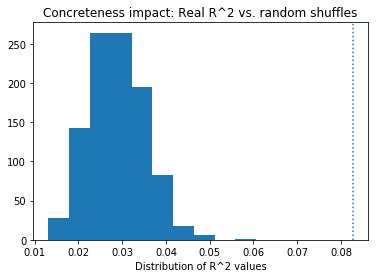

In [12]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Concreteness impact: Real R^2 vs. random shuffles")

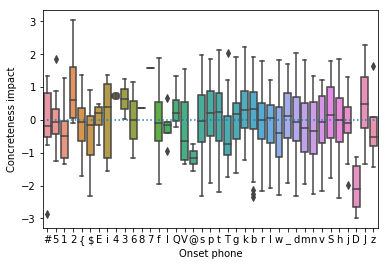

In [13]:
ax = sn.boxplot(data=final_df, x="onset", y="concreteness_impact")
ax.set(xlabel="Onset phone", ylabel="Concreteness impact")
ax.axhline(y=0, linestyle="dotted")

## Discussion and exploration

Based on these results, it seems like:

First, there is more structure in mappings between phonetic onsets and word concreteness than one would expect by chance, one we control for characteristics about the rest of the word.

Certain onsets exhibit particularly strong effects, such as: 
- **/D/** (the onset in *they*) has a consistently *negative* impact on concreteness.
- **/2/** (the onset in *aisle* or *eye*) has a consistently *positive* impact on concreteness.

Other onsets show trends, but not strongly significant trends.

In [14]:
df_merged['initial'] = df_merged['PhonDISC'].apply(lambda x: x[0])

In [15]:
df_merged[df_merged['initial'] == "D"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
3687,they,3.69,1,D1,PRON,1,3.16,D
3679,then,3.27,1,DEn,ADV,1,1.90,D
3672,that,0.00,1,D{t,ADV,1,2.32,D
3670,than,2.72,1,D{n,C,1,1.88,D
3716,thus,2.25,1,DVs,ADV,1,1.97,D


In [16]:
df_merged[df_merged['initial'] == "2"].head(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
83,aisle,1.00,1,2l,N,1,5.09,2
1264,eye,2.72,1,2,N,1,6.34,2
1265,eyrie,0.00,0,2@rI,N,3,5.29,2
1784,ice,1.72,1,2s,N,1,6.21,2
1785,icicle,0.00,0,2sIkP,N,3,5.69,2


## Follow-up: What about without controlling for the rest of the word?

Above, we saw the results when controlling for the rest of the word. What if we don't do this, and just measure *word concreteness* as a function of *onset phone*, while still adding as covariates information about the word length?

In [17]:
df_merged['initial'] = df_merged['PhonDISC'].apply(lambda x: x[0])
df_merged['word_length'] = len(df_merged['PhonDISC'])

In [22]:
result = sm.ols(formula="Concreteness ~ initial + word_length", data=df_merged).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Concreteness   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.515
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           1.04e-31
Time:                        10:27:56   Log-Likelihood:                -4599.2
No. Observations:                2984   AIC:                             9278.
Df Residuals:                    2944   BIC:                             9518.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.857e-07   3.42e-08     14.223      0.000    4.19e-07    5.53e-07
initial[T.$]    -0.1192      0.401     -0.297      0.766      -0.905       0.667
initial[T.1]    -0.3050      0.411     -0.743      0.458      -1.110       0.500
initial[T.2]     0.4568      0.411      1.112      0.266      -0.348       1.262
initial[T.3]     0.5090      0.593      0.859      0.391      -0.653       1.671
initial[T.4]     1.4450      0.860      1.680      0.093      -0.241       3.131
initial[T.5]    -0.1970      0.396     -0.497      0.619      -0.974       0.580
initial[T.6]    -0.4379      0.527     -0.831      0.406      -1.471       0.595
initial[T.7]     0.3500      0.860      0.407      0.684      -1.336       2.036
initial[T.8]     0.4050      0.724      0.559      0.576      -1.014       1.824
initial[T.@]    -0.8319      0.345     -2.413      0.016      -1.508      -0.156
initial[T.D]    -1.8825      0.448     -4.206      0.000      -2.760      -1.005
initial[T.E]    -0.3111      0.352     -0.883      0.377      -1.002       0.379
initial[T.I]    -0.6097      0.332     -1.836      0.066      -1.261       0.041
initial[T.J]     0.7676      0.360      2.133      0.033       0.062       1.473
initial[T.Q]    -0.1739      0.401     -0.434      0.664      -0.960       0.612
initial[T.S]     0.7365      0.353      2.085      0.037       0.044       1.429
initial[T.T]    -0.0398      0.375     -0.106      0.915      -0.775       0.695
initial[T.V]    -0.2482      0.401     -0.619      0.536      -1.034       0.538
initial[T._]     0.2762      0.343      0.804      0.421      -0.397       0.949
initial[T.b]     0.6867      0.315      2.181      0.029       0.069       1.304
initial[T.d]     0.0432      0.319      0.136      0.892      -0.582       0.668
initial[T.f]     0.1048      0.316      0.331      0.740      -0.515       0.725
initial[T.g]     0.3731      0.326      1.146      0.252      -0.265       1.011
initial[T.h]     0.3177      0.322      0.987      0.324      -0.314       0.949
initial[T.i]    -0.0393      0.430     -0.091      0.927      -0.883       0.804
initial[T.j]    -0.1742      0.380     -0.459      0.647      -0.919       0.571
initial[T.k]     0.5431      0.312      1.740      0.082      -0.069       1.155
initial[T.l]     0.2806      0.322      0.872      0.383      -0.350       0.912
initial[T.m]     0.3141      0.316      0.994      0.320      -0.306       0.934
initial[T.n]     0.1407      0.334      0.422      0.673      -0.513       0.795
initial[T.p]     0.3443      0.313      1.100      0.272      -0.270       0.958
initial[T.q]     0.3350      1.178      0.284      0.776      -1.974       2.644
initial[T.r]     0.0670      0.317      0.211      0.833      -0.555       0.689
initial[T.s]     0.3676      0.310      1.186      0.236      -0.240       0.975
initi

In [24]:

### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 1000

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = df_merged.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['initial'])
    new_result = sm.ols(formula="Concreteness ~ shuffled_onset + word_length", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 1000/1000 [00:49<00:00, 13.04it/s]


In [25]:
p_real = len([r for r in shuffled_rsquares if r >= true_rsquare]) / len(shuffled_rsquares)
print("p={p}".format(p=p_real))

p=0.0


Text(0.5,1,'Real R^2 vs. distribution from random permutations')

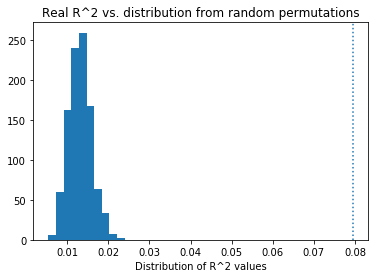

In [26]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Real R^2 vs. distribution from random permutations")

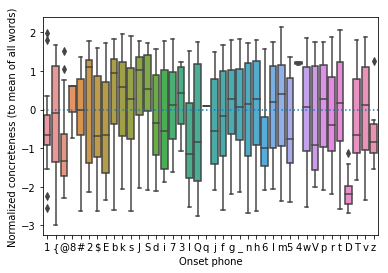

In [27]:
# Rescale
df_merged['Concreteness_normalized'] = df_merged['Concreteness'] - np.mean(df_merged['Concreteness'])

ax = sn.boxplot(data=df_merged, x="initial", y="Concreteness_normalized")
ax.set(xlabel="Onset phone", ylabel="Normalized concreteness (to mean of all words)")
ax.axhline(y=0, linestyle="dotted")

### Follow-up discussion

In the follow-up analysis, we didn't control for features about the rest of the word, and instead asked whether words that begin with particular sounds have systematic differences in their overall concreteness. (Whereas before, we asked whether the same *onset sound* has systematic *impacts* on word concreteness, once we control for the  rest of the word.)

Reassuringly, we see the same trend for **/D/**, which again has a consistent and **strong** negative impact on concreteness. We don't see the same trend for **/2/**, though it's unclear whether this is because it's a null relationship or because there are confounding factors (when we don't control for the rest of the word). Critically, the visualization above is comparing the concreteness of words beginning with a given sound to the *mean* concreteness of all words.

But we also see systematic patterns for a few others:
- Words beginning with **/@/** (e.g. the sound in *away* or *accuser*) are more likely to be **less concrete**.
- Words beginning with **/I/** (e.g. the sound in *exertion* or *exclusion*) are more likely to be **less concrete**.
- Words beginning with **/b/** (e.g. the sound in *body* or *badge*) are slightly more likely to be **more concrete**.
- Words beginning with **/J/** (e.g. *ch-* in cheek) and **/S/** (e.g. "sh" in "shovel") are more concrete.
- Words beginning with **/k/** are weakly more concrete.

In [28]:
df_merged[df_merged['initial'] == "@"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,word_length,Concreteness_normalized
201,assault,1.3,1,@s$lt,N,2,4.10,@,2984,-0.466712
122,amour,0.0,0,@m9R,N,2,3.08,@,2984,-1.486712
2538,originate,1.0,0,@rI_@n1t,V,4,2.85,@,2984,-1.716712
139,annex,0.3,1,@nEks,V,2,4.64,@,2984,0.073288
164,appraise,0.3,0,@pr1z,V,2,2.79,@,2984,-1.776712


In [29]:
df_merged[df_merged['initial'] == "I"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,word_length,Concreteness_normalized
1847,individual,2.00,1,IndIvI_9l,N,4,4.74,I,2984,0.173288
1181,enamel,0.60,1,In{mP,N,3,5.33,I,2984,0.763288
1193,enough,2.50,1,InVf,ADV,2,2.46,I,2984,-2.106712
1831,incident,1.56,1,InsId@nt,N,3,3.40,I,2984,-1.166712
1883,insolent,0.30,0,Ins@l@nt,A,3,3.11,I,2984,-1.456712


In [30]:
df_merged[df_merged['initial'] == "b"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,word_length,Concreteness_normalized
358,bishop,1.51,1,bIS@p,N,2,5.87,b,2984,1.303288
355,bird,2.01,1,b3d,N,1,6.02,b,2984,1.453288
265,bandit,0.48,1,b{ndIt,N,2,5.47,b,2984,0.903288
454,broke,0.48,1,br5k,A,1,3.94,b,2984,-0.626712
276,barn,1.11,1,b#n,N,1,6.14,b,2984,1.573288


In [31]:
df_merged[df_merged['initial'] == "J"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,word_length,Concreteness_normalized
629,chink,0.30,1,JINk,N,1,4.62,J,2984,0.053288
595,champion,1.20,0,J{mpj@n,N,2,4.59,J,2984,0.023288
597,channel,1.52,1,J{nP,N,2,5.27,J,2984,0.703288
618,chestnut,0.70,0,JEsnVt,N,2,6.00,J,2984,1.433288
643,church,2.26,1,J3J,N,1,5.87,J,2984,1.303288


In [32]:
df_merged[df_merged['initial'] == "S"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,word_length,Concreteness_normalized
3270,shear,0.60,1,S7R,V,1,4.56,S,2984,-0.006712
3294,shoulder,2.11,0,S5ld@R,N,2,5.89,S,2984,1.323288
3295,shout,1.08,1,S6t,N,1,4.71,S,2984,0.143288
609,chassis,0.00,1,S{sI,N,2,5.61,S,2984,1.043288
3296,shovel,0.60,1,SVvP,N,2,5.81,S,2984,1.243288
